In [1]:
import pandas as pd
from sklearn import svm
import pickle

C:\Users\assas\AppData\Local\Temp\ipykernel_3404\2319727694.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.drop(train[(train['mean_slope'] == "--") | (train['std_slope'] == "--")].index, inplace=True)
train.isin(["--"]).any()


image_file         False
hand               False
leg                False
hip                False
shoulder           False
mixed              False
label              False
perimeter          False
nm_lns             False
mean_length        False
std_length         False
mean_slope         False
std_slope          False
max_acute_angle    False
min_acute_angle    False
area               False
num_corners        False
corner_ratio       False
dtype: bool

In [4]:
test.drop(test[(test['mean_slope'] == "--") | (test['std_slope'] == "--")].index, inplace=True)
test.isin(["--"]).any()


image_file         False
hand               False
leg                False
hip                False
shoulder           False
mixed              False
label              False
perimeter          False
nm_lns             False
mean_length        False
std_length         False
mean_slope         False
std_slope          False
max_acute_angle    False
min_acute_angle    False
area               False
num_corners        False
corner_ratio       False
dtype: bool

In [5]:
from numpy import mean
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score
X_train = train.drop(columns=['image_file', 'label'])
y_train = train['label']

X_test = test.drop(columns=['image_file', 'label'])
y_test = test['label']


model = svm.SVC(gamma='scale')

param_grid = {
    'class_weight': ({0:1, 1:2}, {0:1,1:4}, {0:1,1:5}),
    'kernel': ('rbf', 'sigmoid'),
    'C': (2, 3),
    'degree': (2, 3)
}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')

grid_result = grid.fit(X_train, y_train)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.310405 using {'C': 3, 'class_weight': {0: 1, 1: 5}, 'degree': 2, 'kernel': 'rbf'}
0.027897 (0.026727) with: {'C': 2, 'class_weight': {0: 1, 1: 2}, 'degree': 2, 'kernel': 'rbf'}
0.250071 (0.034077) with: {'C': 2, 'class_weight': {0: 1, 1: 2}, 'degree': 2, 'kernel': 'sigmoid'}
0.027897 (0.026727) with: {'C': 2, 'class_weight': {0: 1, 1: 2}, 'degree': 3, 'kernel': 'rbf'}
0.250071 (0.034077) with: {'C': 2, 'class_weight': {0: 1, 1: 2}, 'degree': 3, 'kernel': 'sigmoid'}
0.174700 (0.055452) with: {'C': 2, 'class_weight': {0: 1, 1: 4}, 'degree': 2, 'kernel': 'rbf'}
0.277997 (0.029151) with: {'C': 2, 'class_weight': {0: 1, 1: 4}, 'degree': 2, 'kernel': 'sigmoid'}
0.174700 (0.055452) with: {'C': 2, 'class_weight': {0: 1, 1: 4}, 'degree': 3, 'kernel': 'rbf'}
0.277997 (0.029151) with: {'C': 2, 'class_weight': {0: 1, 1: 4}, 'degree': 3, 'kernel': 'sigmoid'}
0.305832 (0.044173) with: {'C': 2, 'class_weight': {0: 1, 1: 5}, 'degree': 2, 'kernel': 'rbf'}
0.281188 (0.027379) with: {'C': 2, 'cla

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       674
           1       0.23      0.33      0.27       142

    accuracy                           0.69       816
   macro avg       0.54      0.55      0.54       816
weighted avg       0.74      0.69      0.71       816

Confusion Matrix:


<Axes: >

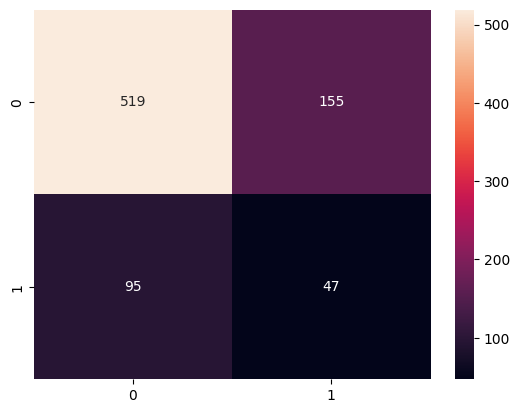

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
weigths = grid_result.best_params_['class_weight']
model = svm.SVC(gamma='scale', class_weight=weigths, kernel=grid_result.best_params_['kernel'], C=grid_result.best_params_['C'], degree=grid_result.best_params_['degree'])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test,y_pred),annot = True,fmt='d')


In [7]:
s = pickle.dump(model, open('./models/svc.pkl', 'wb'))

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import classification_report

# Define the model architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
callback = EarlyStopping(monitor='AUC', patience=3)
# Fit the model to the training data
model.fit(np.asarray(X_train).astype('float32'), np.asarray(y_train).astype('float32'), epochs=30, batch_size=64, class_weight={0: 1, 1: 4}, callbacks=[callback])

Epoch 1/30
51/51 [==============================] - 2s 6ms/step - loss: 4.1220 - accuracy: 0.5286 - auc: 0.5068 - precision: 0.1782 - recall: 0.4650
Epoch 2/30
51/51 [==============================] - 0s 6ms/step - loss: 2.1293 - accuracy: 0.5919 - auc: 0.5435 - precision: 0.2030 - recall: 0.4510
Epoch 3/30
51/51 [==============================] - 0s 6ms/step - loss: 2.0425 - accuracy: 0.6307 - auc: 0.5526 - precision: 0.2179 - recall: 0.4248
Epoch 4/30
51/51 [==============================] - 0s 6ms/step - loss: 1.5171 - accuracy: 0.6448 - auc: 0.5577 - precision: 0.2173 - recall: 0.3916
Epoch 5/30
51/51 [==============================] - 0s 6ms/step - loss: 1.3518 - accuracy: 0.6642 - auc: 0.6201 - precision: 0.2405 - recall: 0.4213
Epoch 6/30
51/51 [==============================] - 0s 6ms/step - loss: 1.2978 - accuracy: 0.6577 - auc: 0.6134 - precision: 0.2507 - recall: 0.4755
Epoch 7/30
51/51 [==============================] - 0s 6ms/step - loss: 1.1813 - accuracy: 0.6790 - auc: 0

In [9]:
# Predict on the test data
y_pred = model.predict(np.asarray(X_test).astype('float32'))

# Convert predictions to binary labels
y_pred_binary = np.round(y_pred)

# Generate classification report
report = classification_report(np.asarray(y_test).astype('float32'), y_pred_binary)
print("Classification Report:")
print(report)

26/26 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.66      0.76       674
         1.0       0.27      0.58      0.37       142

    accuracy                           0.65       816
   macro avg       0.58      0.62      0.56       816
weighted avg       0.78      0.65      0.69       816



<Axes: >

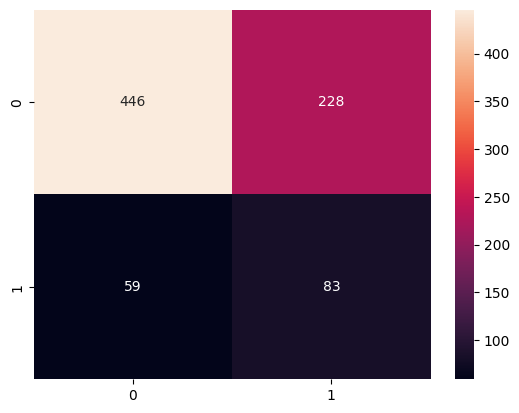

In [10]:
sns.heatmap(confusion_matrix(y_test,y_pred_binary),annot = True,fmt='d')

In [11]:
model.save('./models/nn.h5')

In [12]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'criterion': ('gini', 'entropy'),
    'splitter': ('best', 'random'),
    'max_depth': (None, 10, 20, 30)
}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
model = DecisionTreeClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')

grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_ , grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.346897 using {'criterion': 'gini', 'max_depth': 20, 'splitter': 'random'}
0.307001 (0.062416) with: {'criterion': 'gini', 'max_depth': None, 'splitter': 'best'}
0.336307 (0.063880) with: {'criterion': 'gini', 'max_depth': None, 'splitter': 'random'}
0.285055 (0.064440) with: {'criterion': 'gini', 'max_depth': 10, 'splitter': 'best'}
0.250398 (0.065235) with: {'criterion': 'gini', 'max_depth': 10, 'splitter': 'random'}
0.308872 (0.060398) with: {'criterion': 'gini', 'max_depth': 20, 'splitter': 'best'}
0.346897 (0.054735) with: {'criterion': 'gini', 'max_depth': 20, 'splitter': 'random'}
0.313827 (0.071015) with: {'criterion': 'gini', 'max_depth': 30, 'splitter': 'best'}
0.342552 (0.043514) with: {'criterion': 'gini', 'max_depth': 30, 'splitter': 'random'}
0.322539 (0.046924) with: {'criterion': 'entropy', 'max_depth': None, 'splitter': 'best'}
0.329811 (0.048543) with: {'criterion': 'entropy', 'max_depth': None, 'splitter': 'random'}
0.267545 (0.056750) with: {'criterion': 'ent

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       674
           1       0.30      0.29      0.29       142

    accuracy                           0.76       816
   macro avg       0.57      0.57      0.57       816
weighted avg       0.75      0.76      0.76       816

Confusion Matrix:


<Axes: >

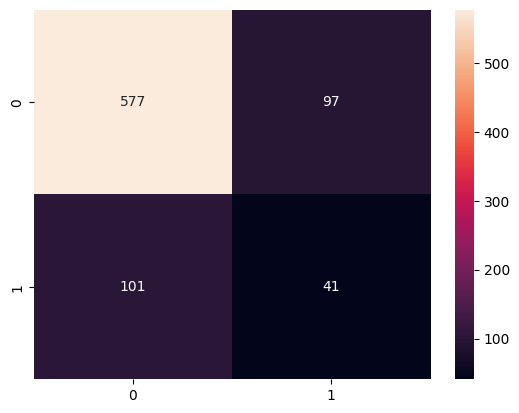

In [15]:
model = DecisionTreeClassifier(criterion='gini', max_depth=20, splitter='random')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test,y_pred),annot = True,fmt='d')

In [16]:
pickle.dump(model, open('./models/dt.pkl', 'wb'))